## V-Shaped Multigrid approach for a 1D diffusion problem
### Abhijeet Sutar

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
from IPython.display import clear_output

In [2]:
@jit(nopython = True)
def ABgen(nx, dx, k, Ar, q, TA, TB):
    A = np.zeros((nx,nx))
    B = np.zeros(nx)
    
    ae = k * Ar / dx
    aw = 0 - ae
    ae2 = 2 * ae
    Sp = 0 - ae2
    Su = q * Ar * dx
    ##for A
    for i in range(nx):
        if (i == 0):
            A[i,i] = 3 * ae
            A[i,i+1] = aw
        elif (i>0) and (i < (nx-1)):
            A[i,i-1] = aw
            A[i,i] = ae2
            A[i,i+1] = aw
        elif (i == (nx-1)) :
            A[i,i-1] = aw
            A[i,i] = 3 * ae
        
    ##for B
    for i in range(nx):
        if (i == 0):
            B[i] = Su + ae2 * TA
        elif (i > 0) and (i < (nx-1)) :
            B[i] = Su
        elif(i == (nx-1)):
            B[i] = Su + ae2 * TB
            
    return A, B

In [3]:
@jit(nopython = True)
def TDMA(nx, dx, k, Ar, q, TA, TB):
    A , B = ABgen(nx, dx, k, Ar, q, TA, TB)
    n = len(B)
    x = np.zeros(n)
    
    for i in range(1,n):
        q = A[i, i-1] / A[i-1,i-1]
        #A[i,i-1] = A[i, i-1] / A[i-1,i-1]
        A[i,i] = A[i,i] - (A[i,i-1] * q)
                   
        B[i] = B[i] - q * B[i-1]
        
    q = B[-1] / A[-1,-1]
    x[-1] = q
    for i in range(n-2, -1, -1):
        q = ( B[i] - A[i,i+1] * q ) / A[i,i]
        x[i] = q
    return x

In [4]:
@jit(nopython = True)
def GaussSeidel(A, B, y):
    ## y is initial guess
    matsize = len(y)
    for i in range(matsize):
        y[i] = 0
        for j in range(matsize):
            if (j!=i) and (A[i,j]!=0):
                y[i] += -A[i,j] / A[i,i] * y[j]
        
        y[i] += B[i] / A[i,i]
        
    return y
    
            

In [5]:
def StdGS1grid(nx, dx, k, Ar, q, TA, TB):
    Ah , Bh = ABgen(nx, dx, k, Ar, q, TA, TB)
    erms = 1
    yh = np.zeros_like(Bh)
    yh[:] = min(TA,TB)
    stepcount = 0
    while(erms > 1e-6):
        yh = GaussSeidel(Ah,Bh,yh)
        rh = residual(Ah,Bh,yh)
        erms = rmsf(rh)
        stepcount +=1
        clear_output(wait=True)
        print(stepcount, erms, flush=True)
    print(stepcount)
    return yh, erms

In [6]:
@jit(nopython = True)
def rmsf(R):
    r = np.sqrt(np.mean(np.square(R)))
    return r

In [7]:
def residual(A, B, y):
    r = np.zeros_like(y)
    r = B - A @ y
    return r

In [8]:
@jit(nopython= True)
def Rextrapolate2(y):
    ## y needs even number of elements
    y2h = np.zeros(int(len(y)/2))
    for i in range(len(y2h)):
        y2h[i] = (y[2*i] + y[2*i+1]) / 2
    
    return y2h

In [9]:
@jit(nopython = True)
def Interpolateback2(e):
    ## e is a vector
    xaxis = len(e)
    yaxis = 2 * len(e) 
    I = np.zeros((yaxis, xaxis))
    j_arr = np.arange(len(e)) + 1
    for j in j_arr:
        if (j != 1):
            I[2*j-3,j-1] = 0.25
        I[2*j-2,j-1] = 0.75
        I[2*j-1,j-1] = 0.75
        if (j != j_arr[-1]):
            I[2*j  ,j-1] = 0.25
        
    return I

In [10]:
def V2multgrid(nx, dx, k, Ar, q, TA, TB):
    if ((nx % 4) != 0):
        print("use nx value divisible by 4")
        return 
    Ah , Bh = ABgen(nx, dx, k, Ar, q, TA, TB)
    erms = 1
    yh = np.zeros_like(Bh)
    yh[:] = min(TA,TB)
    stepcount = 0
    while(erms > 1e-6):
        ## fine grid
        for i in range(5):
            yh = GaussSeidel(Ah,Bh,yh)
            stepcount +=1
        rh = residual(Ah,Bh,yh)
        r2h = Rextrapolate2(rh)
        
        ## half resolution
        A2h, B2h = ABgen(int(nx/2), 2*dx, k, Ar, q, TA, TB)
        e2h = np.zeros_like(r2h)
        for i in range(10):
            e2h = GaussSeidel(A2h,r2h,e2h)
            stepcount +=1
        r2h = residual(A2h,r2h,e2h)
        r4h = Rextrapolate2(r2h)
        
        ## quarter resolution
        A4h, B4h = ABgen(int(nx/4), 4*dx, k, Ar, q, TA, TB)
        e4h = np.zeros_like(r4h)
        for i in range(10):
            e4h = GaussSeidel(A4h,r4h,e4h)
            stepcount +=1
        r4h = residual(A4h,r4h,e4h)
        
        ## Interpolate
        ep2h = Interpolateback2(e4h)@e4h
        ec2h = e2h + ep2h
        
        ##smoothening
        for i in range(2):
            ec2h = GaussSeidel(A2h,r2h,ec2h)
            stepcount +=1
        
        ##final Interpolation
        eph = Interpolateback2(ec2h)@ec2h
        yc = yh + eph
        
        rfh = residual(Ah,Bh,yc)
        erms = rmsf(rfh)
        
        clear_output(wait=True)
        print(stepcount, erms, flush=True)
    
    print(stepcount)
    return yc, erms 

In [11]:
# RR = 01(B17ME001)
%timeit ymultG, ermsmultG = V2multgrid(20, 0.05, 5, 0.01, 20e3, 101, 501)

3618 9.409480278510592e-07
3618
265 ms ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit y1G, erms1G = StdGS1grid(20, 0.05, 5, 0.01, 20e3, 101, 501)

666 9.931054224053007e-07
666
1.08 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit x = TDMA(20, 0.05, 5, 0.01, 20e3, 101, 501)

The slowest run took 8.10 times longer than the fastest. This could mean that an intermediate result is being cached.
6.84 µs ± 7.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
ymultG, ermsmultG = V2multgrid(20, 0.05, 5, 0.01, 20e3, 101, 501)
y1G, erms1G = StdGS1grid(20, 0.05, 5, 0.01, 20e3, 101, 501)
x = TDMA(20, 0.05, 5, 0.01, 20e3, 101, 501)

666 9.931054224053007e-07
666


In [15]:
format_row = "{:<25}" * (4)
print(format_row.format("TDMA solution", "Multi Grid", "Error Multi grid", "Error Percentage MG"))
for i in range(len(x)):
    print(format_row.format(x[i], ymultG[i], x[i] - ymultG[i], (x[i] - ymultG[i])/x[i]*100))

TDMA solution            Multi Grid               Error Multi grid         Error Percentage MG      
160.99999999999997       160.9999980686496        1.931350368522544e-06    1.1995965021879159e-06   
270.99999999999994       270.99999177320854       8.226791408105782e-06    3.035716386754902e-06    
371.0                    370.99998666861705       1.333138294512537e-05    3.5933646752359487e-06   
461.0                    460.9999819668949        1.8033105106951552e-05   3.911736465716172e-06    
541.0                    540.999977831657         2.2168342979966837e-05   4.097660439919934e-06    
611.0                    610.999974311232         2.568876800523867e-05    4.204381015587344e-06    
670.9999999999999        670.9999715152898        2.8484710128395818e-05   4.245113282920391e-06    
720.9999999999998        720.9999694678937        3.053210605230561e-05    4.234688772857921e-06    
760.9999999999998        760.9999682168433        3.17831564871085e-05     4.1764988813546e

In [16]:
format_row = "{:<25}" * (4)
print(format_row.format("TDMA solution", "Single Grid GS", "Error Single grid", "Error Percentage SG"))
for i in range(len(x)):
    print(format_row.format(x[i], y1G[i], x[i] - y1G[i], (x[i] - y1G[i])/x[i]*100))

TDMA solution            Single Grid GS           Error Single grid        Error Percentage SG      
160.99999999999997       160.99999503568256       4.964317412259334e-06    3.083426964136233e-06    
270.99999999999994       270.99998547128          1.4528719930240186e-05   5.361151265771287e-06    
371.0                    370.9999764961156        2.3503884392539476e-05   6.335278812005249e-06    
461.0                    460.9999683152814        3.168471857861732e-05    6.873040906424581e-06    
541.0                    540.9999611094269        3.8890573136995954e-05   7.188645681514963e-06    
611.0                    610.9999550309385        4.4969061491428874e-05   7.359911864390977e-06    
670.9999999999999        670.9999502009044        4.9799095449998276e-05   7.4216237630399835e-06   
720.9999999999998        720.9999467069183        5.329308146428957e-05    7.39155082722463e-06     
760.9999999999998        760.9999446017562        5.5398243603121955e-05   7.27966407399763

Text(0, 0.5, 'Temperature in deg C')

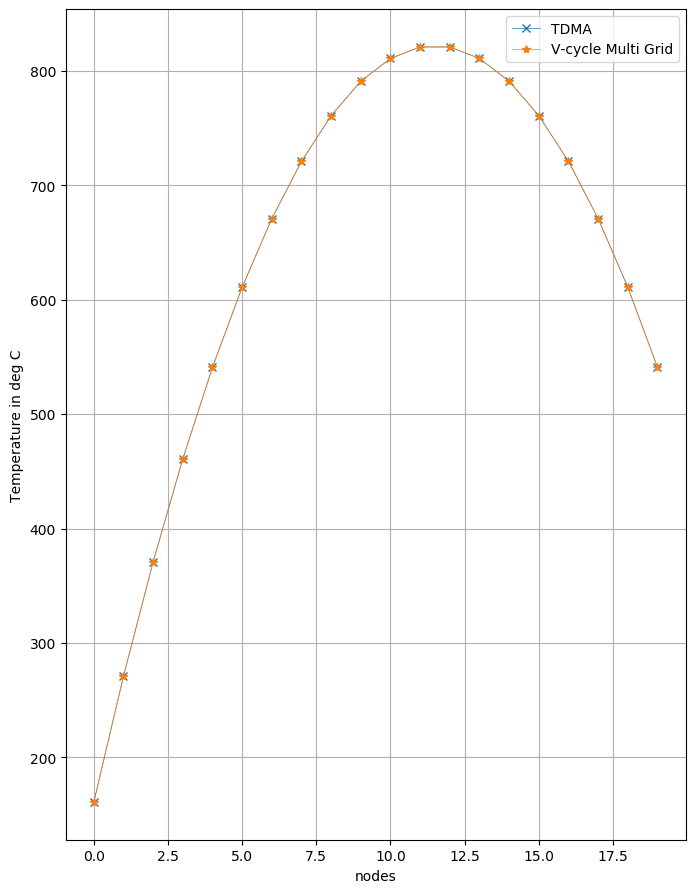

In [17]:
fig1 = plt.figure(figsize = (8,11), dpi = 100)
plt.plot(x, marker = "x", label = "TDMA", linewidth = 0.5)
plt.plot(ymultG, marker = "*", label="V-cycle Multi Grid", linewidth = 0.5)
plt.grid()
plt.legend()
plt.xlabel("nodes")
plt.ylabel("Temperature in deg C")


In [18]:
y = np.zeros(5)
A = np.array([[375,-125,0,0,0], [-125,250,-125,0,0],[0,-125,250,-125,0],[0,0,-125,250,-125],[0,0,0,-125,375]])
B = np.array([29000,4000,4000,4000,54000])
A, B

(array([[ 375, -125,    0,    0,    0],
        [-125,  250, -125,    0,    0],
        [   0, -125,  250, -125,    0],
        [   0,    0, -125,  250, -125],
        [   0,    0,    0, -125,  375]]),
 array([29000,  4000,  4000,  4000, 54000]))

In [19]:
n = len(B)
x = np.zeros(n)

for i in range(1,n):
    q = A[i, i-1] / A[i-1,i-1]
    #A[i,i-1] = A[i, i-1] / A[i-1,i-1]
    A[i,i] = A[i,i] - (A[i,i-1] * q)

    B[i] = B[i] - q * B[i-1]

q = B[-1] / A[-1,-1]
x[-1] = q
for i in range(n-2, -1, -1):
    q = ( B[i] - A[i,i+1] * q ) / A[i,i]
    x[i] = q
    
x

array([150.74805874, 220.24417621, 257.15830921, 260.26836643,
       230.96750903])